<a href="https://colab.research.google.com/github/hululuzhu/cn-text-to-pic/blob/main/cn_text_to_image_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 趣味中文生成图片 demo

利用现成的语言和图片生成及鉴别模型来接受中文输入输出图片。
- 中文到英文采用 [HuggingFace Helsinki-NLP](https://huggingface.co/Helsinki-NLP)
- 英文到图片生成采用 [VQGAN](https://compvis.github.io/taming-transformers/)
- 图片鉴别使用OpenAI的[CLIP](https://openai.com/blog/clip/)
- VQGAN和CLIP合起来有一个[pixray project](https://github.com/dribnet/pixray)

其他相关文章和笔记本
- https://medium.com/towards-data-science/how-i-built-an-ai-text-to-art-generator-a0c0f6d6f59f
- https://colab.research.google.com/github/justinjohn0306/VQGAN-CLIP/blob/main/VQGAN%2BCLIP_%28z%2Bquantize_method_with_augmentations%2C_user_friendly_interface%29.ipynb
- https://colab.research.google.com/github/dribnet/clipit/blob/master/demos/Swap_Model.ipynb

last update: 10/2021

# 第一步，启动GPU，确认有10G以上显存
- 没有大的GPU？那就和我一样乖乖买colab pro吧

In [8]:
!nvidia-smi -i 0 -q -d MEMORY


==============NVSMI LOG==============

Timestamp                                 : Tue Oct 19 03:47:31 2021
Driver Version                            : 460.32.03
CUDA Version                              : 11.2

Attached GPUs                             : 1
GPU 00000000:00:04.0
    FB Memory Usage
        Total                             : 16280 MiB
        Used                              : 2 MiB
        Free                              : 16278 MiB
    BAR1 Memory Usage
        Total                             : 16384 MiB
        Used                              : 2 MiB
        Free                              : 16382 MiB



# 第二部，必要的引用

In [9]:
%%capture
!git clone https://github.com/openai/CLIP
!git clone https://github.com/CompVis/taming-transformers.git
!rm -Rf pixray
!git clone https://github.com/dribnet/pixray
!pip install -q ftfy regex tqdm omegaconf pytorch-lightning
!pip install -q kornia
!pip install -q imageio-ffmpeg   
!pip install -q einops
!pip install -q torch-optimizer
!pip install -q easydict
!pip install -q braceexpand
!pip install -q git+https://github.com/pvigier/perlin-numpy
!pip install transformers -q
!pip install -q sentencepiece
!mkdir steps
!mkdir models

import sys
sys.path.append("pixray")
import pixray
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

# 第三步，启动中文翻译模型
- 注意此处为节省显存给图像模型，翻译模型移至CPU

In [15]:
# Initialize the tokenizer
tokenizer = AutoTokenizer.from_pretrained("Helsinki-NLP/opus-mt-zh-en")

# Initialize the model
zh_en_model = AutoModelForSeq2SeqLM.from_pretrained("Helsinki-NLP/opus-mt-zh-en")
zh_en_model = zh_en_model.to("cpu")

In [60]:
def translate_cn_to_en(text):
  tokenized_text = tokenizer.prepare_seq2seq_batch([text], return_tensors='pt')
  # Perform translation and decode the output
  translation = zh_en_model.generate(**tokenized_text)
  translated_text = tokenizer.batch_decode(translation, skip_special_tokens=True)[0]
  return translated_text

translate_cn_to_en('两个小朋友在学校里骑车')

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:3402: FutureWarning: 
`prepare_seq2seq_batch` is deprecated and will be removed in version 5 of HuggingFace Transformers. Use the regular
`__call__` method to prepare your inputs and the tokenizer under the `as_target_tokenizer` context manager to prepare
your targets.

Here is a short example:

model_inputs = tokenizer(src_texts, ...)
with tokenizer.as_target_tokenizer():
    labels = tokenizer(tgt_texts, ...)
model_inputs["labels"] = labels["input_ids"]

See the documentation of your specific tokenizer for more details on the specific arguments to the tokenizer of choice.
For a more complete example, see the implementation of `prepare_seq2seq_batch`.

  warnings.warn(formatted_warning, FutureWarning)


'Two kids riding at school.'

# 第四步，启动VQGAN并测试英文生成图片
- 模型最开始的英文是不同的图片集，个人感觉wikiart_16384模糊画风最好用，imagenet最写实但有点奇怪，coco一直有错误，还没解决
- 模型最后的数字是vocab大小，越大支持的冷门词汇越多
- 此处需要8G以上显存。可以使用`torch.cuda.empty_cache() `或者`tf.config.experimental.set_memory_growth(tf.config.experimental.list_physical_devices('GPU'), True)`来释放显存

In [46]:
vqgan_model = "wikiart_16384" #@param ["imagenet_f16_16384", "imagenet_f16_1024", "openimages_f16_8192", "wikiart_1024", "wikiart_16384", "coco"]

def generate_img(en_prompt, vqgan_model=vqgan_model, make_video=False,
                 quality="normal"):
  pixray.reset_settings()
  pixray.add_settings(prompts=en_prompt, vqgan_model=vqgan_model)
  pixray.add_settings(display_clear=True)
  pixray.add_settings(display_every=10)
  pixray.add_settings(iterations=200)
  pixray.add_settings(make_video=make_video)
  pixray.add_settings(quality=quality)
  settings = pixray.apply_settings()
  pixray.do_init(settings)
  pixray.do_run(settings)

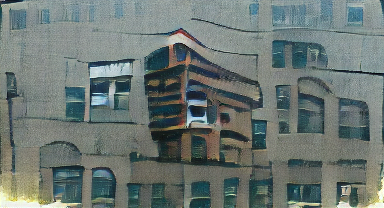

iter: 200, finished (-8=>1.651)


In [53]:
# 测试一个例子来启动模型
generate_img("building across the street")

# 最后，组合翻译和生成模型

In [24]:
def generate_cn_img(cn_txt_prompt, model=vqgan_model, make_video=False, quality="normal"):
  en_prompt = translate_cn_to_en(cn_txt_prompt)
  generate_img(cn_txt_prompt, model, make_video, quality)

### wikiart_16384 比较抽象

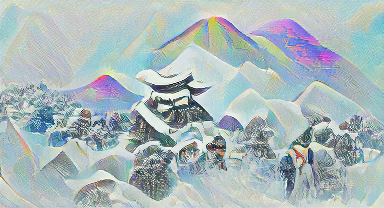

iter: 200, finished (-20=>1.585)
Generating video...


  0%|          | 0/199 [00:00<?, ?it/s]

In [52]:
generate_cn_img('白雪覆盖高山', model="wikiart_16384") 

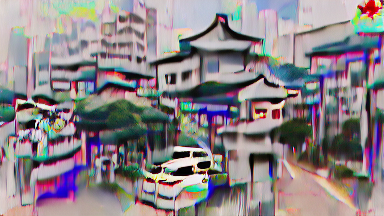

iter: 200, finished (-16=>1.63)


In [54]:
generate_cn_img('城市的高楼')

### openimages_f16_8192 比较写实

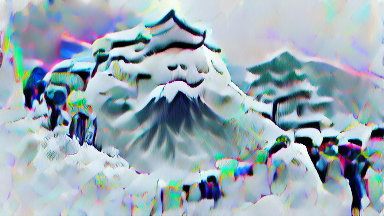

iter: 200, finished (-21=>1.554)


In [57]:
generate_cn_img('白雪覆盖高山', model="openimages_f16_8192") 

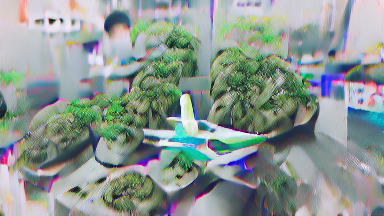

iter: 200, finished (-24=>1.615)


In [58]:
generate_cn_img('城市的高楼上空有一架飞机', model="openimages_f16_8192") 

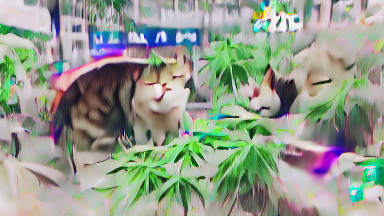

iter: 200, finished (-6=>1.547)


In [59]:
generate_cn_img('草地上有两只大熊猫', model="openimages_f16_8192") 

# 简单总结
- 模型对于简单非描述性的内容能生成和输入文字还算搭配的图片，比如“城市的高楼”或者“白雪覆盖高山”
- 一旦文字中多了描述性的语言，比如“五彩斑斓的楼房”，或者“可爱的熊猫”，结果就有点奇怪
- 所以，只能用来娱乐一下 ^_^

## 奇怪的例子

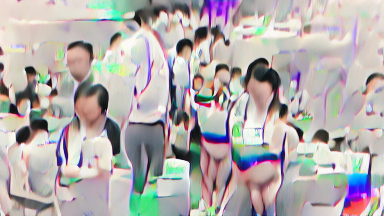

iter: 200, finished (-24=>1.657)


In [56]:
generate_cn_img('五彩斑斓的楼房') 

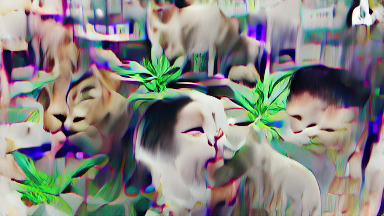

iter: 200, finished (-18=>1.597)


In [55]:
generate_cn_img('可爱的熊猫') 